In [131]:
# Cargar librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse

# q-q plots
import scipy.stats as stats

In [2]:
# Se cargan los datos de entrenamiento

df_original = pd.read_csv('data/university_admission_train.csv', sep=',', encoding = 'utf-8', index_col=0)
df_tracks = df_original.copy()
print(df_tracks.shape)
df_tracks.head(5)

(1569, 9)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,479,327,113,4,4.00,2.77,8.88,1,84.47
1,446,301,92,1,1.85,1.50,7.71,0,45.08
2,336,297,100,1,2.41,1.59,7.89,0,47.42
3,20,303,98,3,3.50,3.00,8.50,0,62.00
4,432,320,94,2,1.38,3.50,8.78,1,73.00


In [3]:
# Se cargan los datos de prueba

df_recent = pd.read_csv('data/university_admission_test.csv', sep=',', encoding = 'utf-8')
print(df_recent.shape)
df_recent.head(5)

(175, 8)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,117,299,102,3,4.0,3.5,8.62,0
1,49,321,110,3,3.5,5.0,8.85,1
2,94,301,97,2,3.0,3.0,7.88,1
3,108,338,117,4,3.5,4.5,9.46,1
4,327,299,100,3,2.0,2.0,8.02,0


In [83]:
# Analizar la duplicidad de los datos

df_recent.duplicated().sum()

15

In [84]:
# Analizar la completitud de los datos

df_recent.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
dtype: int64

# Identificación de variables a utlizar

In [33]:
df_num = df_tracks_prep.select_dtypes(['number']).copy()
df_num.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000
mean,307.693809,101.553163,2.880888,2.976770,3.018964,8.347537,0.470390,66.795962
std,17.894184,12.501348,1.242870,1.236833,1.215772,0.812251,0.499291,19.277668
min,257.000000,69.000000,1.000000,0.020000,0.000000,6.100000,0.000000,34.000000
25%,298.000000,96.000000,2.000000,2.000000,2.035000,7.770000,0.000000,48.000000
50%,309.000000,103.500000,3.000000,3.000000,3.000000,8.340000,0.000000,67.000000
75%,322.000000,111.000000,4.000000,4.000000,4.000000,9.050000,1.000000,84.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,145.500000


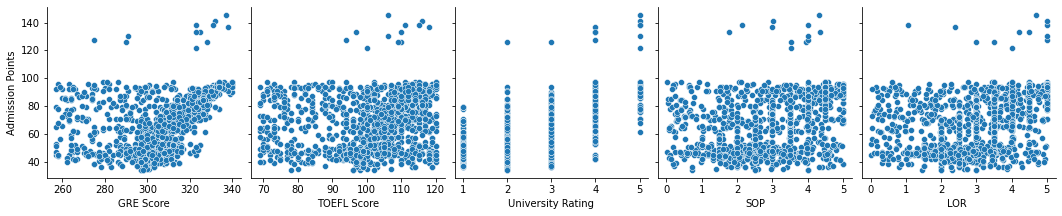

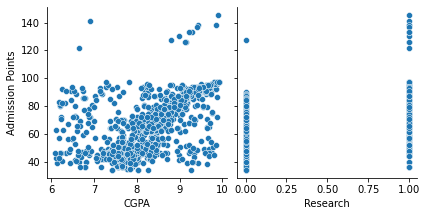

In [34]:
# Diagramas de disperción con respecto a la variable objetivo

sns.pairplot(df_tracks_prep, height=3, y_vars = 'Admission Points', x_vars = df_tracks_prep.columns[0:5], kind='scatter')
sns.pairplot(df_tracks_prep, height=3, y_vars = 'Admission Points', x_vars = df_tracks_prep.columns[5:7], kind='scatter')

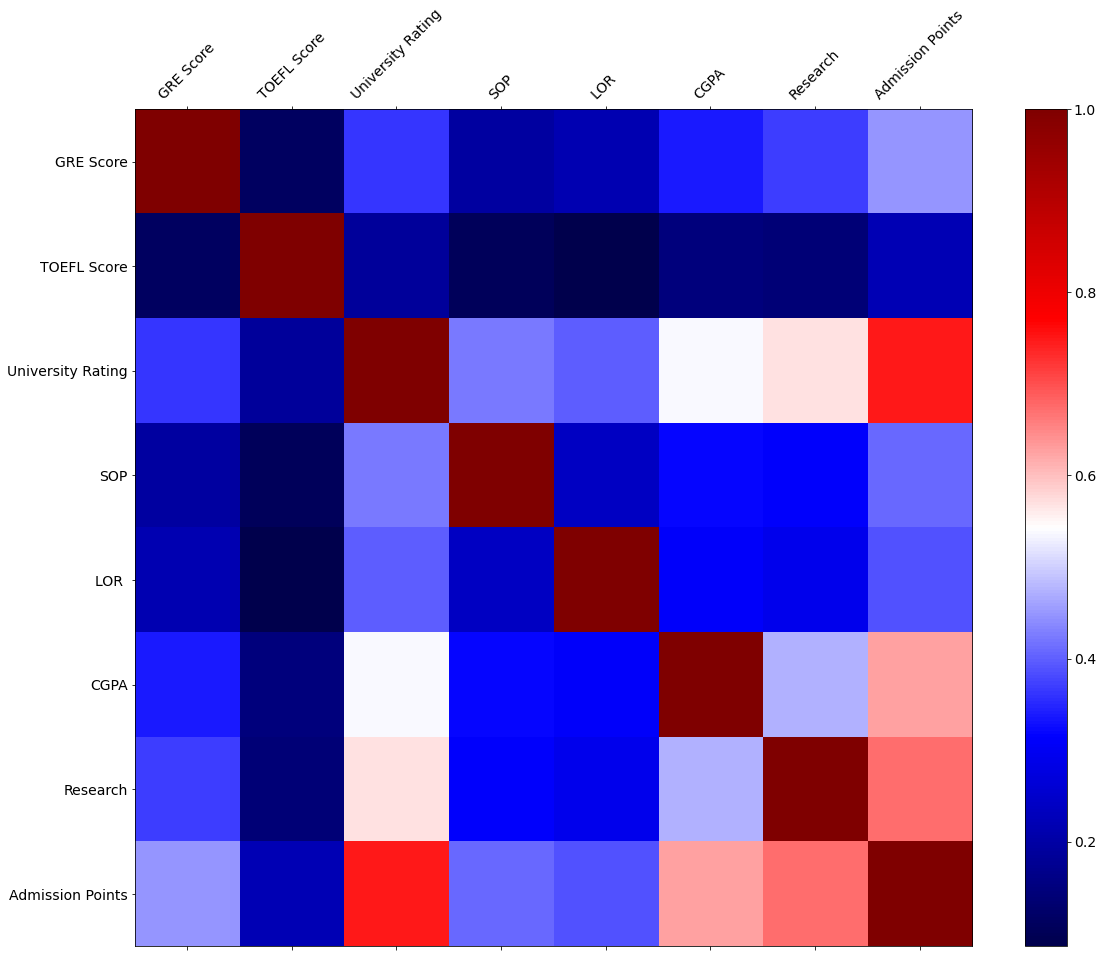

In [35]:
# Matriz de correlaciones para ver la relación entre variables

f = plt.figure(figsize=(19, 15))
plt.matshow(df_num.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)

# Preparación de los datos

In [53]:
def square(X):
    for feature in X.columns:
        if feature=='CGPA' or feature=='GRE Score':
            X[feature]=np.sqrt(X[feature])
    return X

def dropNa(X):
     return X.dropna()

# def dropDup(X):
#     return X.drop_duplicates()  

def print1(X):
    print(X)
    return X

In [136]:
#Preparación datos de entrenamiento
selected_cols = ['University Rating','CGPA','Research','GRE Score','Admission Points']

t=[ ("selector", 'passthrough',selected_cols)]

pre_all = [('na', FunctionTransformer(dropNa)), #Se eliminan las filas con puntaje de admisión nulo
           ('initial',ColumnTransformer(transformers = t)), #seleccionar unicamente las columnas que se quieren usar
           ('scaler', MinMaxScaler())] #Escalar los datos de -1 a 1

In [137]:
##Se crea el pipeline de preparación
pipeline1 = Pipeline(pre_all)

In [138]:
# Ejecutamos la preparación y volvemos a poner los datos en un dataframe
d = pipeline1.fit_transform(df_tracks)
d = pd.DataFrame(data=d,columns=['University Rating','CGPA','Research','GRE Score', 'Admission Points'])
d

,University Rating,CGPA,Research,GRE Score,Admission Points
0,0.75,0.727749,1.0,0.843373,0.452646
1,0.00,0.421466,0.0,0.530120,0.099372
2,0.00,0.468586,0.0,0.481928,0.120359
3,0.50,0.628272,0.0,0.554217,0.251121
4,0.25,0.701571,1.0,0.759036,0.349776
...,...,...,...,...,...
1499,0.25,0.350785,0.0,0.493976,0.121076
1500,0.00,0.500000,1.0,0.662651,0.161435
1501,0.00,0.138743,0.0,0.421687,0.121435
1502,0.25,0.594241,0.0,0.662651,0.269058


In [170]:
# Preparación datos para entrenar

selected_cols = ['University Rating','CGPA','Research']

t=[ ("selector", 'passthrough',selected_cols)]

pre = [('square', FunctionTransformer(square)), #Sacamos la raíz cuadrada de la columna CGPA para que su relación se ajuste más a una recta
       ('initial',ColumnTransformer(transformers = t)), #seleccionar unicamente las columnas que se quieren usar
       ('scaler', MinMaxScaler()), #Escalar los datos de -1 a 1
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))] #Reemplazamos los valores nulos por la mediana de la columna.


# Modelo

In [109]:
# Se genera el modelo

model = [('model', LinearRegression())]

In [110]:
#Se crea el pipeline de entrenamiento
pipeline = Pipeline(pre+model)

In [111]:
# Se extrae las variables explicativas y objetivo para entrenar

X = d[selected_cols]
y = d['Admission Points']

# Se entrena el modelo
pipeline = pipeline.fit(X,y)

/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


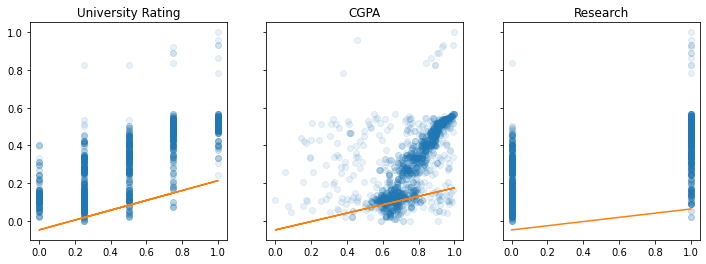

In [112]:
# Se visualiza la regresión lineal en cada dimensión

f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):

    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X[col]
    # Pendiente
    m = pipeline['model'].coef_[pos_col]
    # Interceto
    b = pipeline['model'].intercept_

    axs[i].plot(x, y, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)

In [139]:
# Usamos la lbreria joblib
filename = 'modelo.joblib'
# Se guarda
dump(pipeline, filename) 

['modelo.joblib']

In [114]:
# Se lee
p2 = load(filename)
p2

Pipeline(steps=[('square',
                 FunctionTransformer(func=<function square at 0x7f8f43ee2ae8>)),
                ('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['University Rating', 'CGPA',
                                                   'Research'])])),
                ('scaler', MinMaxScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('model', LinearRegression())])

In [124]:
# Clasificamos los datos recientes
df_recent1=df_recent
df_recent1['Admission Points'] = p2.predict(df_recent1)

(array([18.,  3., 41., 10., 21., 25.,  8., 26.,  3., 20.]),
 array([0.81239837, 0.93810731, 1.06381626, 1.1895252 , 1.31523415,
        1.44094309, 1.56665204, 1.69236098, 1.81806993, 1.94377887,
        2.06948782]),
 <BarContainer object of 10 artists>)

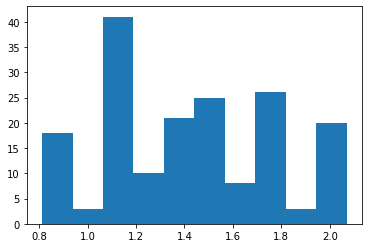

In [134]:
#Visualizamos la predicción de puntajes

#sns.histplot(df_recent['Admission Points'])
plt.hist(df_recent['Admission Points'])

In [135]:
#Vemos la importancia de los features con los que entrenamos
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

,columns,coef
0,University Rating,0.261297
1,CGPA,0.222895
2,Research,0.110978


In [120]:
# Extraemos las variables explicativas y objetivo para entrenar

X = d.drop('Admission Points', axis = 1)
y = d['Admission Points']

pipeline = pipeline.fit(X,y)

In [121]:
# Imprimir los coeficientes nuevamente

pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

,columns,coef
0,University Rating,0.261297
1,CGPA,0.222895
2,Research,0.110978


# Evaluación cuantitativa

In [122]:
# R²
p2.score(X,y)

0.6466565504809838

In [123]:
#RMSE

y_true = y
y_predicted = p2.predict(X)

# Note que hay que sacarle la raiz al valor
np.sqrt(mse(y_true, y_predicted))

0.10845831355644821

**¿Su equipo recomienda instalar el modelo de estimación en producción o es mejor continuar usando expertos para la tarea?**

El modelo de estimación de nuestro equipo muestra unas metricas buenas, sin embargo aun creemos que no son lo suficientemente adecuados para ser puestos en producción. Una vez las metricas alcancen R^2 > 0.8 y RSME < 0.06, consideramos que el modelo es suficiente para el uso en producción. Por lo tanto, por el momento se recomienta continuar usando expertos para la tarea y seguir ajustando el modelo

**En caso de no recomendar el uso de un modelo de regresión ¿Qué otras posibilidades tiene la empresa? ¿Hacia dónde debe seguir con esta tarea?**

En este caso se podría recomendar en vez de intentar predecir el puntaje de admisión, acordar un puntaje suficientemente bueno para decidir si un candidato es elegible y convertir esto a una tarea de aprendizaje de clasificación. Este tipo de aprendeizaje consideramos que resuelve las necesidades presentadas.

# Evaluación cualitativa

## Validación de supuestos
**¿Qué obtuvieron con el ejercicio de regresión?**

Con el modelo de regresión obtuvimos un sistema cuantitativo para estimar el puntaje de admision de un candidato.

## Interpretación de los coeficientes
**¿Cuáles son las variables más influyentes y que tan confiables son los resultados?**

Nuestros resultados indican que las variables mas influyentes, en orden de influencia son las siguientes:
    - University Rating
    - sqrt(CGPA)
    - Research
    
Los resultados son bastante confiables segun las metricas obtenidas del modelo. Sin embargo, como ya fue expresado previamente, no consideramos que sean aun lo suficientemente confiables para ser usadas en un ambiente de producción.

# Preparación datos de prueba

In [192]:
X1 = df_recent[['Research']]
X1.to_csv("data/pruebas/prueba1.csv")
X1.to_json("data/pruebas/prueba1.json")
X1

,Research
0,0
1,1
2,1
3,1
4,0
...,...
170,1
171,0
172,0
173,0


In [176]:
"Error"
try:
    p2.predict(X1)
except Exception as err:
    print(err)

columns are missing: {'CGPA', 'University Rating'}


In [193]:
X2 = pd.DataFrame(np.ones((len(X1),3)),columns=selected_cols)
X2.to_csv("data/pruebas/prueba2.csv")
X2.to_json("data/pruebas/prueba2.json")
X2

,University Rating,CGPA,Research
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
...,...,...,...
170,1.0,1.0,1.0
171,1.0,1.0,1.0
172,1.0,1.0,1.0
173,1.0,1.0,1.0


In [181]:
"Resultados sin sentido"
try:
    print(p2.predict(X2))
except Exception as err:
    print(err)

[0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578
 0.54693578 0.54693578 0.54693578 0.54693578 0.54693578 0.5469

In [204]:
X3 = np.ones((len(X1),3))
X3[:]=np.nan
X3 = pd.DataFrame(X3,columns=selected_cols)
X3.to_csv("data/pruebas/prueba3.csv")
X3.to_json("data/pruebas/prueba3.json")
X3

,University Rating,CGPA,Research
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
170,NaN,NaN,NaN
171,NaN,NaN,NaN
172,NaN,NaN,NaN
173,NaN,NaN,NaN


In [191]:
"Resultados sin sentido"
try:
    res = p2.predict(X3)
    print(res)
except Exception as err:
    print(err)

     University Rating  CGPA  Research
0                  NaN   NaN       NaN
1                  NaN   NaN       NaN
2                  NaN   NaN       NaN
3                  NaN   NaN       NaN
4                  NaN   NaN       NaN
..                 ...   ...       ...
170                NaN   NaN       NaN
171                NaN   NaN       NaN
172                NaN   NaN       NaN
173                NaN   NaN       NaN
174                NaN   NaN       NaN

[175 rows x 3 columns]
[0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725 0.25271725
 0.25271725 0.25271725 0.25271725 0.252

In [216]:
X4 = df_recent[selected_cols]
X4[selected_cols[0]]-=1
X4[selected_cols[1]]+=np.mean(X4[selected_cols[1]])
X4[selected_cols[2]]=-(X4[selected_cols[2]]-1)
X4.to_csv("data/pruebas/prueba4.csv")
X4.to_json("data/pruebas/prueba4.json")
print(min(X4[selected_cols[0]]))
X4

0


/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,University Rating,CGPA,Research
0,2,3.417176,1
1,2,3.428493,0
2,1,3.379155,0
3,3,3.457475,0
4,2,3.386548,1
...,...,...,...
170,3,3.446717,0
171,0,3.369504,1
172,0,3.373277,1
173,1,3.402069,1


In [209]:
"Resultados con sentido"
try:
    res = p2.predict(X4)
    print(res)
except Exception as err:
    print(err)

[1.12398136 1.01479529 0.74573153 1.28070642 1.11916247 0.85712365
 1.27861229 1.27838555 1.12038774 1.28173889 0.85435707 0.85579141
 1.01316073 1.11616236 0.85160205 1.27936474 1.54215129 0.74705227
 1.27732123 0.85520319 1.01761709 1.28319755 1.53975798 1.12095474
 1.11548381 0.59549537 1.5419291  0.85486556 1.00965351 1.12460786
 0.86134108 0.59648669 1.28239763 0.853504   1.53899933 0.74964537
 1.28055814 0.5976316  1.11800593 0.85679217 1.53838861 0.85307481
 0.85770123 1.00818487 0.8616587  0.85670914 0.74964537 1.27539457
 0.59314519 0.85794781 0.85469634 0.48689774 0.74851865 1.54449434
 0.86562882 1.01409777 0.8600611  1.53838861 1.01464067 0.85965794
 1.01323912 1.27996304 0.85495007 0.8586841  0.85637635 0.48890752
 1.27996304 1.65474498 0.75736945 1.11616236 0.8560425  1.27013691
 1.37575438 0.59482926 1.54449434 1.64673192 0.59373772 1.01394216
 1.12499759 1.01776758 1.28055814 0.85670914 1.54500044 1.01245259
 1.38898422 1.38321656 0.85579141 1.01378632 0.85786568 0.8546

/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [217]:
df_recent.to_csv("data/pruebas/prueba5.csv")
df_recent.to_json("data/pruebas/prueba5.json")

In [215]:
"Resultados con sentido"
try:
    res = p2.predict(df_recent)
    print(res)
except Exception as err:
    print(err)

[1.11758112 1.23108126 0.95878724 1.49883805 1.11075422 0.84840064
 1.49591283 1.49559546 1.11249594 1.50027637 0.84444705 0.84649948
 1.22878006 1.10647213 0.84048833 1.49696514 1.76034129 0.96066866
 1.49410401 0.84565848 1.23503799 1.50230406 1.75699814 1.11330054
 1.10550013 0.58663127 1.7600315  0.84517533 1.223819   1.11846419
 0.85438719 0.58804365 1.50119271 0.8432236  1.75593545 0.96434882
 1.49863128 0.58967151 1.10910644 0.84792807 1.75507895 0.84260729
 0.84922336 1.22173182 0.85483613 0.84780964 0.96434882 1.4913969
 0.58327193 0.8495743  0.84493305 0.70099521 0.96275199 1.76360086
 0.86042562 1.2301001  0.85257533 1.75507895 1.23086387 0.85200375
 1.22889059 1.49780088 0.8452963  0.85062126 0.84733482 0.70384293
 1.49780088 1.65161333 0.97520729 1.10647213 0.84685817 1.48396055
 1.36532439 0.58568071 1.76360086 1.64039605 0.58412035 1.22988104
 1.11901302 1.23524845 1.49863128 0.84780964 1.76430321 1.22778098
 1.38408718 1.37596481 0.84649948 1.2296616  0.84945743 0.84493